In [1]:
import jax
import jax.lax as lax
import jax.numpy as jnp
from jax.random import key, split, uniform

import matplotlib.pyplot as plt

from baum_welch_jax.algorithms import baum_welch, generate_sequence
from baum_welch_jax.models import HiddenMarkovModel



jax.config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=3)

In [4]:
from matplotlib.figure import Figure
import numpy as np

def plot_hmm_params(hmm: HiddenMarkovModel) -> tuple[Figure, np.ndarray]:
    n, m = hmm.O.shape
    fig, ax = plt.subplots(1, 3, width_ratios=(n, m, 1))
    fig.set_size_inches(5,2)

    if hmm.is_log:
        hmm = hmm.to_prob()

    ax[0].imshow(hmm.T)
    ax[0].set_title("T")
    ax[1].imshow(hmm.O)
    ax[1].set_title("O")
    ax[2].imshow(hmm.mu[:,None])
    ax[2].set_title(r"$\mu$")
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    
    return fig, ax

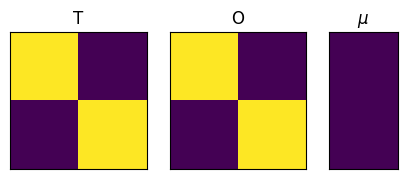

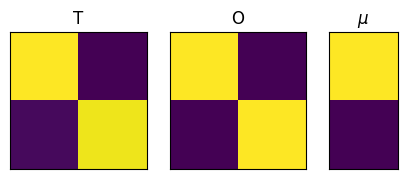

Likelihood is nondecreasing: True


Array([1.158e+00, 6.287e-04, 6.321e-04, 6.383e-04, 6.473e-04, 6.592e-04,
       6.739e-04, 6.915e-04, 7.122e-04, 7.360e-04, 7.631e-04, 7.937e-04,
       8.281e-04, 8.664e-04, 9.089e-04, 9.562e-04, 1.009e-03, 1.067e-03,
       1.131e-03, 1.203e-03, 1.283e-03, 1.372e-03, 1.472e-03, 1.586e-03,
       1.714e-03, 1.860e-03, 2.028e-03, 2.221e-03, 2.447e-03, 2.711e-03,
       3.022e-03, 3.394e-03, 3.841e-03, 4.383e-03, 5.047e-03, 5.871e-03,
       6.904e-03, 8.215e-03, 9.902e-03, 1.211e-02, 1.503e-02, 1.899e-02,
       2.445e-02, 3.218e-02, 4.338e-02, 6.016e-02, 8.617e-02, 1.283e-01,
       1.998e-01, 3.292e-01, 5.808e-01, 1.117e+00, 2.392e+00, 5.822e+00,
       1.582e+01, 3.931e+01, 5.042e+01, 1.899e+01, 4.343e+00, 1.623e+00,
       7.274e-01, 3.744e-01, 2.153e-01, 1.342e-01, 8.863e-02, 6.113e-02,
       4.357e-02, 3.187e-02, 2.381e-02, 1.810e-02, 1.397e-02, 1.093e-02,
       8.652e-03, 6.932e-03, 5.615e-03, 4.596e-03, 3.801e-03, 3.174e-03,
       2.676e-03, 2.278e-03, 1.955e-03, 1.693e-03, 

In [ ]:
T = jnp.array(
    [
        [0.9, 0.1], 
        [0.1,0.9]
    ]
)
O = jnp.eye(2)
mu = jnp.array([0.5, 0.5])
hmm = HiddenMarkovModel(T, O, mu).to_log()

init_guess = HiddenMarkovModel(
    jnp.ones((2,2)) / 2, 
    jnp.ones((2,2)) / 2, 
    jnp.array([0.8,0.2]))

states, obs = generate_sequence(key(0), hmm, 500)
result = baum_welch(obs, init_guess, max_iter=100, epsilon=1e-10, mode='log')

fig, ax = plot_hmm_params(hmm)
plt.show()

fig, ax = plot_hmm_params(result.params)
plt.show()

print('Likelihood is nondecreasing:', bool(jnp.all(jnp.diff(result.log_likelihoods[:result.iterations]) >= 0)))
jnp.diff(result.log_likelihoods[:result.iterations])

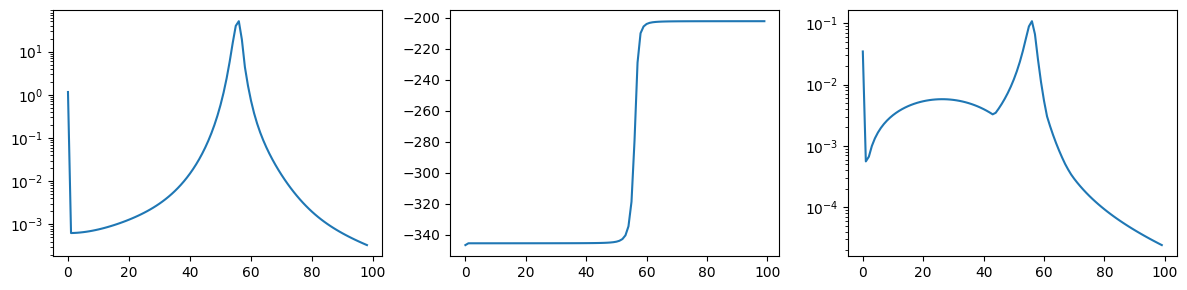

100 False


HiddenMarkovModel(T=Array([[0.869, 0.131],
       [0.15 , 0.85 ]], dtype=float64), O=Array([[9.995e-01, 4.883e-04],
       [1.057e-07, 1.000e+00]], dtype=float64), mu=Array([1.000e+000, 2.866e-151], dtype=float64), is_log=False)

In [19]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12,3)
ax[0].semilogy(jnp.diff(result.log_likelihoods))
ax[1].plot(result.log_likelihoods[:result.iterations])
ax[2].semilogy(result.residuals)
plt.tight_layout()
plt.show()

print(result.iterations, result.terminated)
result.params.to_prob()

In [ ]:
seed = 2345
n = 4 # Number of states
m = 3 # Number of observations
# Construct a transition matrix that stays in the same state with 99% probability and transitions to the next with 1%
T = 0.95 * jnp.eye(n, dtype=jnp.float64)
T = T + 0.05 * jnp.eye(n, k=1)
T = T / jnp.sum(T, axis=-1)[:,None]

# Construct an initial state distribution where the earlier states are more likely
mu = jnp.exp(-jnp.linspace(0, 10, n, dtype=jnp.float64))
mu = mu.at[n -1].set(0)
mu = mu / jnp.sum(mu)

# Construct a noisy observation matrix
O = jnp.zeros((n, m), dtype=jnp.float64)
O = O * jnp.linspace(0, 1, n)[:, None]
O = O.at[0, 0].set(1.0)
for s in range(n):
    O = O.at[s].set(jnp.exp(- ((jnp.arange(m) - (s*m) / n)**2)/(s + 1)))
O = O.at[n-1].set(0.0)
O = O.at[n-1, m-1].set(1.0)
O = O / jnp.sum(O, axis=-1)[:,None]

hmm = HiddenMarkovModel(T, O, mu)

print("T row sums:", jnp.sum(T, axis=-1), 
      "\nO row sums:", jnp.sum(O, axis=-1), 
      "\nmu sum:", jnp.sum(mu)[None])


T row sums: [1. 1. 1. 1.] 
O row sums: [1. 1. 1. 1.] 
mu sum: [1.]


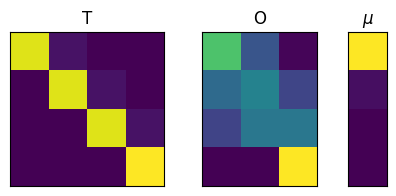

In [ ]:
fig, ax = plot_hmm_params(hmm)
plt.show()

In [ ]:
from baum_welch_jax.algorithms import generate_sequence

n_sequences = 100
len_sequence = 100
rng_key, *sequence_keys = split(key(seed), 1 + n_sequences)

generate = jax.jit(lambda _key: generate_sequence(_key, hmm, len_sequence))

states, observations = jax.vmap(generate)(jnp.array(sequence_keys))

print("states.shape =", states.shape)

states.shape = (100, 100)


In [ ]:
key_T, key_O, key_mu = split(rng_key, 3)

_T = uniform(key_T, T.shape)
_O = uniform(key_O, O.shape)
_mu = uniform(key_mu, mu.shape)


_T = _T / jnp.sum(_T, axis=1)[:, None]
_O = _O / jnp.sum(_O, axis=1)[:, None]
_mu = _mu / jnp.sum(_mu)


init_guess = HiddenMarkovModel(_T, _O, _mu)
result = baum_welch(observations, init_guess, max_iter=5000, epsilon=1e-15, mode='log')

In [ ]:
result.residuals.shape

(1000,)

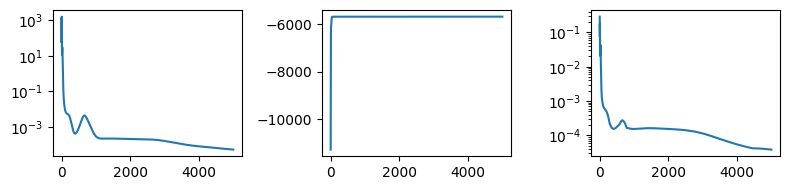

5000 False


HiddenMarkovModel(T=Array([[4.249e-002, 8.925e-001, 5.870e-002, 6.276e-003],
       [7.925e-001, 2.075e-001, 9.737e-074, 5.955e-043],
       [5.206e-214, 5.992e-005, 9.999e-001, 0.000e+000],
       [2.088e-028, 5.039e-002, 0.000e+000, 9.496e-001]], dtype=float64), O=Array([[0.225, 0.507, 0.268],
       [0.301, 0.378, 0.321],
       [0.   , 0.   , 1.   ],
       [0.694, 0.285, 0.021]], dtype=float64), mu=Array([0., 0., 0., 1.], dtype=float64), is_log=False)

In [ ]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(8,2)
ax[0].semilogy(jnp.diff(result.log_likelihoods[:result.iterations]))
ax[1].plot(result.log_likelihoods[:result.iterations])
ax[2].semilogy(result.residuals[:result.iterations])
plt.tight_layout()
plt.show()

print(result.iterations, result.terminated)
result.params.to_prob()

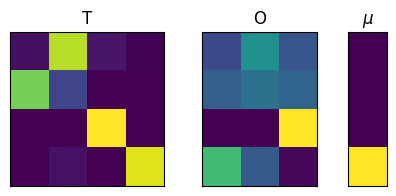

In [ ]:
fig, ax = plot_hmm_params(result.params)
plt.show()

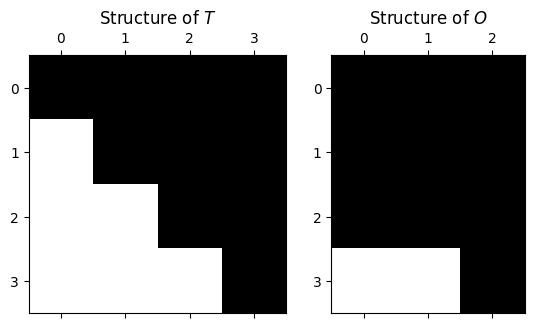

In [ ]:
T_structure = jnp.triu(jnp.ones_like(T, dtype=jnp.float64))
O_structure = jnp.ones_like(O, dtype=jnp.float64)
O_structure = O_structure.at[n-1, :m-1].set(0)

fig, ax = plt.subplots(1,2, width_ratios=(n, m))
ax[0].spy(T_structure)
ax[0].set_title("Structure of $T$")
ax[1].spy(O_structure)
ax[1].set_title("Structure of $O$")
plt.show()

In [ ]:
key_T, key_O, key_mu = split(key(334), 3)

_T = uniform(key_T, T.shape) * T_structure
_O = uniform(key_O, O.shape) * O_structure
_mu = uniform(key_mu, mu.shape)


_T = _T / jnp.sum(_T, axis=1)[:, None]
_O = _O / jnp.sum(_O, axis=1)[:, None]
_mu = _mu / jnp.sum(_mu)
init_guess = HiddenMarkovModel(_T, _O, _mu)
result = baum_welch(observations, init_guess, max_iter=1000, epsilon=1e-15, mode='log')

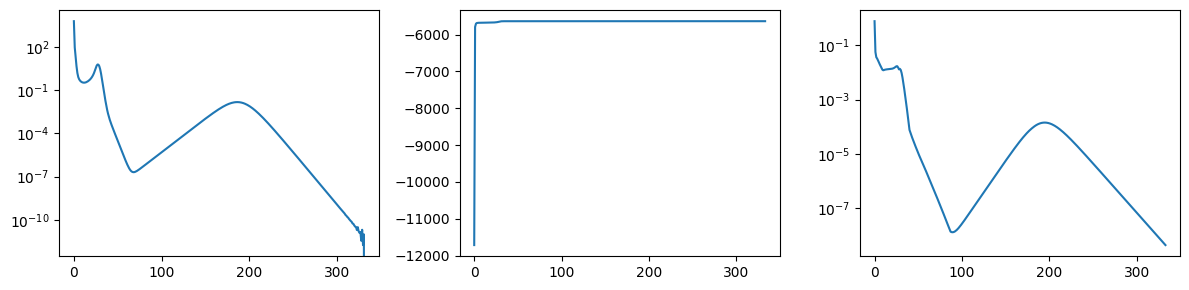

334 False


HiddenMarkovModel(T=Array([[9.468e-001, 4.622e-002, 6.972e-003, 3.481e-191],
       [0.000e+000, 9.603e-001, 3.528e-002, 4.440e-003],
       [0.000e+000, 0.000e+000, 9.500e-001, 5.005e-002],
       [0.000e+000, 0.000e+000, 0.000e+000, 1.000e+000]], dtype=float64), O=Array([[0.715, 0.268, 0.017],
       [0.36 , 0.449, 0.191],
       [0.193, 0.406, 0.401],
       [0.   , 0.   , 1.   ]], dtype=float64), mu=Array([1., 0., 0., 0.], dtype=float64), is_log=False)

In [ ]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12,3)
ax[0].semilogy(jnp.diff(result.log_likelihoods))
ax[1].plot(result.log_likelihoods[:result.iterations])
ax[2].semilogy(result.residuals)
plt.tight_layout()
plt.show()

print(result.iterations, result.terminated)
result.params.to_prob()

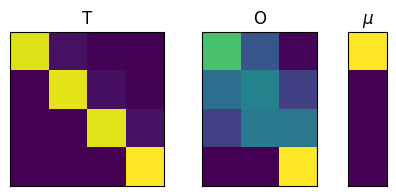

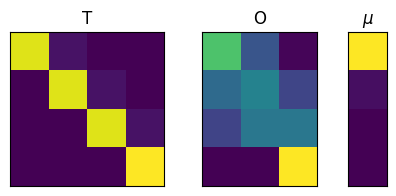

In [ ]:
fig, ax = plot_hmm_params(result.params)
plt.show()

fig, ax = plot_hmm_params(hmm)
plt.show()


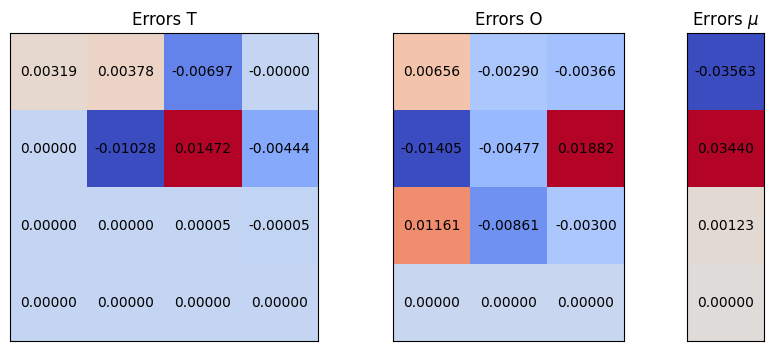

In [ ]:
import numpy as np
fig, ax = plt.subplots(1, 3, width_ratios=(n, m, 1))
fig.set_size_inches(10,4)

res_hmm = result.params.to_prob()

errors = [
    T - res_hmm.T,
    O - res_hmm.O,
    mu[:,None] - res_hmm.mu[:,None]
]

labels = [
    'T',
    'O',
    '$\\mu$'
]

for k, (err_mat, label) in enumerate(zip(errors, labels)):
    ax[k].matshow(err_mat, cmap='coolwarm')
    for (i, j), z in np.ndenumerate(err_mat):
        ax[k].text(j, i, '{:0.5f}'.format(z), ha='center', va='center')
    ax[k].set_title(f"Errors {label}")
    ax[k].set_xticks([])
    ax[k].set_yticks([])
plt.show()